In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os
import multiprocessing

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)

import jax
jax.config.update('jax_platform_name', 'cpu')

platform = jax.lib.xla_bridge.get_backend().platform.casefold()
print("Platform: ", platform)

Platform:  cpu


In [8]:
len(jax.devices())

28

In [9]:
from functools import partial
import jax.numpy as jnp
import jax.random as jr
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.gaussian_obs import e_step_par, add0
from jax import grad, hessian
import matplotlib.pyplot as plt

from cohlib.utils import pickle_save, gamma_root, pickle_open
from cohlib.jax.gamma_create import k2_full

from pathlib import Path
from omegaconf import OmegaConf

In [10]:
def load_results(paths, ovs_sel, **kwargs):
    Lpaths = get_model_paths(paths, **kwargs)
    results = {}
    obs_vars = []
    for path in Lpaths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)
        obs_var = cfg.obs.ov2
        if ovs_sel is not None:
            if obs_var in ovs_sel:
                obs_vars.append(obs_var)

    ovs = jnp.array(obs_vars)
    if ovs.size == jnp.unique(ovs).size:

        for path in Lpaths:
            cfg_path = os.path.join(path, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)
            obs_var = cfg.obs.ov2

            res = pickle_open(os.path.join(path, 'res.pickle'))
            res['cfg'] = cfg
            results[obs_var] = res

    else:
        print('Duplicates found for obs_var - returning empty dict.')

    return results

def get_model_paths(paths, **kwargs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)

            if cfg.latent.L == L:
                if cfg.model.emiters == emiters:
                    if cfg.model.init == init:
                        if cfg.model.scale_init == scale_init:
                            if supp is not None:
                                if 'support' in list(cfg.model.keys()):
                                    if cfg.model.support == supp:
                                            sel_paths.append(exp)
                            else:
                                if 'support' not in list(cfg.model.keys()):
                                    if cfg.model.emiters == emiters:
                                        sel_paths.append(exp)
                                else:
                                    if cfg.model.support == supp:
                                            sel_paths.append(exp)
    return sel_paths

### Data setup

In [11]:
flow = 1
fhigh = 50
scalep_target = 5
scalep_offtarget = 1

In [12]:
gamma_load = pickle_open(f'gammas/k2-full{flow}-{fhigh}-10-{scalep_target}-{scalep_offtarget}.pickle')
gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
nz = gamma_load['nonzero_inds']
K = gamma_full.shape[1]

We'll want to use the same seed here as we used in the batch runs, so let's load that and simulate latent / observations

We'll use the following observation variance for now, but plan to look at others in the next notebook.

In [13]:
ov1 = 1
ov2 = -1
obs_var = ov1 * 10**ov2

- For this observation variance (1e-1):
    - Simulate observations (using Jax lib)
    - Choose $\Gamma^{(r)}$ for EM step $r+1$ 
        - flat / true / intermediate
    - For Jax vs Old:
        - Look at cost/grad/hess at first and last step of optimization in E-Step
            - Note:
                - Recall thet optimization always starts at origin
                - Can profile cost/grad/hess throughout optimization later if bug still not found
        - Check cost/grad/hess at true zs


In [14]:
scale_init = 10
res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/batch_submit/outputs/2024-08-07']

L = 25
init = 'flat-init'
emiters = 20
scale_init = 10
ovs_sel = None

supp = [0, 50]
res_load = load_results(res_paths, ovs_sel, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

In [15]:
cfg = res_load[ov2]['cfg']
lcfg = cfg.latent
ocfg = cfg.obs

lrk = jr.key(lcfg.seed)
ork = jr.key(ocfg.seed)

L = 25
zs = sample_from_gamma(lrk, gamma_full, L)

zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

Visualizing the simulated data:

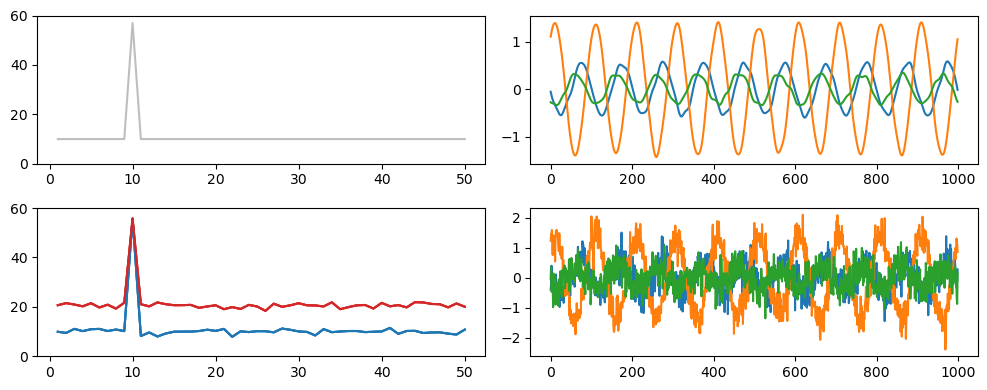

In [16]:
oracle_est = jnp.einsum('jkl,jil->jkil', zs, zs.conj()).mean(-1)
obs_f = jnp.fft.rfft(obs, axis=0)
zs_naive = obs_f[1:,:,:]
naive_est = jnp.einsum('jkl,jil->jkil', zs_naive, zs_naive.conj()).mean(-1)

dB = True
fig, ax = plt.subplots(2,2,figsize=(10,4))
S_true = gamma_full[nz,0,0].real
S_oracle = oracle_est[nz,0,0].real
S_naive = naive_est[nz,0,0].real
# ax[1,0].plot(S_true, color='tab:grey', alpha=0.5)

if dB == True:
    S_true = 10*jnp.log10(S_true+1e-15)
    S_oracle = 10*jnp.log10(S_oracle+1e-15)
    S_naive = 10*jnp.log10(S_naive+1e-15)

ax[0,0].plot(freqs[nz], S_true, color='tab:grey', alpha=0.5)
for l in range(3):
    ax[1,0].plot(freqs[nz], S_oracle, color='tab:blue')
    ax[1,0].plot(freqs[nz], S_naive, color='tab:red')
    ax[0,1].plot(xs[:,0,l])
    ax[1,1].plot(obs[:,0,l])
ax[0,0].set_ylim([0,60])
ax[1,0].set_ylim([0,60])
plt.tight_layout()

### Setting things up for both Jax / Old models


##### Jax model 

In [20]:
Nnz = nz.size
K = obs.shape[1]
nz_target = jnp.array([9])
params = {'obs_var': obs_var,
          'freqs': freqs,
          'nonzero_inds': nz}


##### Old model setup

In [18]:
def conv_grad_old_r2c(grad_vec_real, K):
    rs = grad_vec_real.reshape(2,-1).swapaxes(0,1)
    grad_vec_complex = conv_v_to_z(rs, axis=0)
    return grad_vec_complex

conv_mus_old_r2c = conv_grad_old_r2c


In [24]:
def load_old(ov2, mu=0.0, K=2, L=25, sample_length=1000, C=1, ov1=1.0, seed=8, etype="approx", hess_mod=False):
    exp_path = '/projectnb/stephenlab/jtauber/cohlib/experiments/gaussian_observations'
    ov2 = float(ov2)
    if hess_mod is True:
        model_path = f'{exp_path}/saved/fitted_models/scale_hess_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_path)
    else:
        model_path = f'{exp_path}/saved/fitted_models/scale_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_path)

    return model_load

old_model_load = load_old(ov2)
Wv = old_model_load['Wv']
sample_length = Wv.shape[0]
num_J_vars = Wv.shape[1]

Next:
- Pick a $\Gamma^{(r)}$

- initialize the Jax/Old Models 

- investigate cost/grad/hess behavior 

## $\Gamma^{(r)} = \Gamma$

In [26]:
from cohlib.alg.em_sgc import construct_Gamma_full_real, deconstruct_Gamma_full_real
gamma_inv_nonzero_init = jnp.stack([jnp.eye(K, dtype=complex) for _ in range(Nnz)])*(1/1000)
gamma_target_inv = jnp.copy(jnp.linalg.inv(gamma_full[nz_target,:,:]))

gamma_inv_init = jnp.zeros_like((gamma_full))
gamma_inv_init = gamma_inv_init.at[nz,:,:].set(gamma_inv_nonzero_init)
gamma_inv_init = gamma_inv_init.at[nz_target,:,:].set(gamma_target_inv)

gamma_prev_inv = gamma_inv_init
gamma_init = jnp.zeros_like(gamma_full)
gamma_init = gamma_init.at[nz,:,:].set(jnp.linalg.inv(gamma_inv_init[nz,:,:]))

gamma_prev_inv_oldformat = construct_Gamma_full_real(gamma_prev_inv[nz,:,:], K, num_J_vars, invert=False)

In [35]:
from cohlib.jax.gaussian_obs import get_e_step_cost_func
from cohlib.alg.laplace_gaussian_obs import TrialDataGaussian, GaussianTrial

trial = 0
test_data = obs[:,:,trial]

cost_func_jax = get_e_step_cost_func(test_data, gamma_prev_inv, params)
cost_grad_jax = jax.grad(cost_func_jax, holomorphic=True)
cost_hess_jax = jax.hessian(cost_func_jax, holomorphic=True)

invQ = jnp.diag(jnp.ones(sample_length)*(1/obs_var))
obs_objs = [GaussianTrial(test_data[None,:,i], invQ) for i in range(K)] 
trial_obj = TrialDataGaussian(obs_objs, gamma_prev_inv_oldformat, Wv)

cost_func_old = trial_obj.cost_func()
cost_grad_old = trial_obj.cost_grad()
cost_hess_old = trial_obj.cost_hess()

##### cost/grad/hess on true zs

In [39]:
from cohlib.utils import conv_z_to_v, conv_v_to_z
zs_use = zs[nz,:,trial]
vs_use = conv_z_to_v(zs_use, axis=0)

grad_jax = cost_grad_jax(zs_use).conj()
hess_jax = cost_hess_jax(zs_use)
hess_jax_sel = jnp.stack([hess_jax[n,:,n,:] for n in range(Nnz)])

In [43]:
vs_use_list = jnp.concatenate([vs_use[:,k] for k in range(K)])

grad_old_real = cost_grad_old(vs_use_list)

grad_old = conv_grad_old_r2c(grad_old_real, K)

print(grad_jax[:2,0])
print(grad_old[:2,0])

[ 0.0943716 +0.18769367j -0.06452217+0.25321534j]
[ 0.0938658 +0.18791671j -0.06182092+0.24726279j]


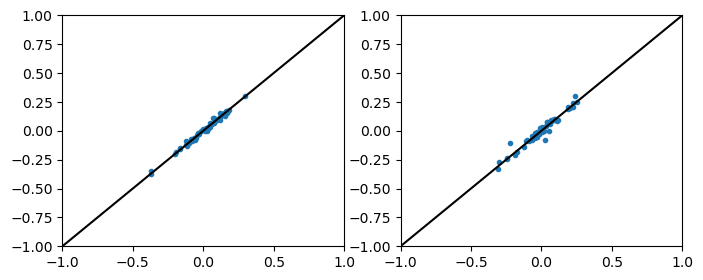

In [44]:
k = 0
pltlim = 1
yxline = jnp.linspace(-pltlim, pltlim, 100)
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(grad_jax[:,k].real, grad_old[:,k].real, '.')
ax[0].set_xlim([-pltlim, pltlim])
ax[0].set_ylim([-pltlim, pltlim])
ax[0].plot(yxline, yxline, 'k')

ax[1].plot(grad_jax[:,k].imag, grad_old[:,k].imag, '.')
ax[1].set_xlim([-pltlim, pltlim])
ax[1].set_ylim([-pltlim, pltlim])
ax[1].plot(yxline, yxline, 'k')

In [47]:
hess_old_full_real = cost_hess_old(vs_use_list)
hess_old = deconstruct_Gamma_full_real(hess_old_full_real, K, num_J_vars)

In [49]:
hess_jax_temp = cost_hess_jax(zs_use)
hess_jax = jnp.stack([hess_jax_temp[n,:,n,:] for n in range(Nnz)])

In [51]:
j = 5
rnd = 3
print(jnp.round(hess_old[j,:,:], rnd))
print(jnp.round(hess_jax[j,:,:], rnd))

# cool - so it looks like we at least have this issue here
# let's confirm it's still a factor of 2 when we use a different obs var
# confirmed

# so one first thing we can try is running the (old) algorithm with two modifications
# first - use the scaled Wv
# second - divide the Hessian value by 2 

[[0.041+0.j 0.   +0.j]
 [0.   +0.j 0.041+0.j]]
[[0.022-0.j 0.   +0.j]
 [0.   +0.j 0.022-0.j]]


Great, now before cleaning this up, what else will we want to do? 
- different obs var
    - different Gamma (flat, intermediate, true)
        - Look at cost/grad/hess for:
            - different zs
                - 0 init
                - optimized zs

        - Run E-Step and look at:
            - mus
            - cost/grad/hess at mus
        - Run M-Step 
            - Use same set of mus and look at jax vs old

so, let's write:
    - an 'inspect' function for jax / old that takes args (data, obs var, gamma, zs) and returns cost/grad/hess 


In [59]:
def jax_inspect_optim(data, zs, gamma_inv, params):
    cost_func_jax = get_e_step_cost_func(data, gamma_inv, params)
    cost_grad_jax = jax.grad(cost_func_jax, holomorphic=True)
    cost_hess_jax = jax.hessian(cost_func_jax, holomorphic=True)

    cost_jax = cost_func_jax(zs)
    grad_jax = cost_grad_jax(zs).conj()
    hess_jax = cost_hess_jax(zs)
    hess_jax_sel = jnp.stack([hess_jax[n,:,n,:] for n in range(Nnz)])

    res = {'cost': cost_jax, 'grad': grad_jax, 'hess': hess_jax_sel}
    return res

In [53]:
test_res = jax_inspect_optim(test_data, zs_use, gamma_prev_inv, params)

In [ ]:
params = {'obs_var': obs_var, 'Wv': Wv}

In [63]:
from cohlib.jax.gaussian_obs import get_e_step_cost_func
from cohlib.alg.laplace_gaussian_obs import TrialDataGaussian, GaussianTrial

trial = 0
test_data = obs[:,:,trial]

def old_inspect_optim(data, zs, gamma_inv, params, return_type='complex'):
    K = data.shape[1]
    obs_var = params['obs_var']
    nz = params['nz']
    Wv = params['Wv']
    num_J_vars = Wv.shape[1]

    invQ = jnp.diag(jnp.ones(sample_length)*(1/obs_var))

    obs_objs = [GaussianTrial(data[None,:,i], invQ) for i in range(K)] 
    gamma_inv_oldformat = construct_Gamma_full_real(gamma_inv[nz,:,:], K, num_J_vars, invert=False)
    trial_obj = TrialDataGaussian(obs_objs, gamma_inv_oldformat, Wv)


    cost_func_old = trial_obj.cost_func()
    cost_grad_old = trial_obj.cost_grad()
    cost_hess_old = trial_obj.cost_hess()

    vs = conv_z_to_v(zs, axis=0)
    vs_flat = jnp.concatenate([vs[:,k] for k in range(K)])

    cost_old_real = cost_func_old(vs_flat)
    grad_old_real = cost_grad_old(vs_flat)
    hess_old_full_real = cost_hess_old(vs_use_list)

    if return_type == 'complex':
        grad_old = conv_grad_old_r2c(grad_old_real, K)
        hess_old = deconstruct_Gamma_full_real(hess_old_full_real, K, num_J_vars)
        res = {'cost': cost_old_real, 'grad': grad_old, 'hess': hess_old}
    else:
        res = {'cost': cost_old_real, 'grad': grad_old_real, 'hess': hess_old_full_real}

    return res

In [66]:
test_jax = jax_inspect_optim(test_data, zs_use, gamma_prev_inv, params)

params_old = {'obs_var': obs_var, 'Wv': Wv, 'nz': nz}
test_old = old_inspect_optim(test_data, zs_use, gamma_prev_inv, params_old)

##### cost/grad/hess on true zs

In [ ]:
from cohlib.utils import conv_z_to_v, conv_v_to_z
zs_use = zs[nz,:,trial]
vs_use = conv_z_to_v(zs_use, axis=0)

grad_jax = cost_grad_jax(zs_use).conj()
hess_jax = cost_hess_jax(zs_use)
hess_jax_sel = jnp.stack([hess_jax[n,:,n,:] for n in range(Nnz)])

In [ ]:
vs_use_list = jnp.concatenate([vs_use[:,k] for k in range(K)])

grad_old_real = cost_grad_old(vs_use_list)

grad_old = conv_grad_old_r2c(grad_old_real, K)

print(grad_jax[:2,0])
print(grad_old[:2,0])

[ 0.0943716 +0.18769367j -0.06452217+0.25321534j]
[ 0.0938658 +0.18791671j -0.06182092+0.24726279j]


In [ ]:
# data = obs
# track = [gamma_init]
# mus_track = []
# for r in range(20):
#     print(f'EM Iter {r+1}')
#     mus_all, Upss = e_step_par(data, gamma_prev_inv, params, Ups_diag=True, return_mus=True)
#     mus = mus_all[0]
#     mus_outer = mus_all[1]
#     gamma_update = m_step(mus_outer, Upss)

#     gamma_prev_inv_model = jnp.linalg.inv(gamma_update)
#     gamma_prev_inv = jnp.zeros_like(gamma_full)
#     gamma_prev_inv = gamma_prev_inv.at[nz,:,:].set(gamma_prev_inv_model)

#     track.append(gamma_update)
#     mus_track.append(mus)

In [ ]:
# def plot_spec_em_iters(ax, gamma_iter_list, k, nz=None, dB=False):
#     if nz is None:
#         nz = jnp.arange(gamma_iter_list[0].shape[0])
#     num_iters = len(gamma_iter_list)
#     color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
#     for r, c in enumerate(color): 
#         gamma_r = gamma_iter_list[r]
#         S_r = gamma_r[nz,k,k].real
#         if dB is True:
#             S_r = 10*jnp.log10(S_r)
#         ax.plot(S_r, color=c, linewidth=2, alpha=0.8)

# dB = True
# fig, ax = plt.subplots()
# S_init = gamma_init[nz,k,k].real
# if dB is True:
#     S_init = 10*jnp.log10(S_init)
# k = 0
# plot_spec_em_iters(ax, track[1:], k, nz, dB=dB)
# ax.plot(S_init, color='tab:grey', linestyle='--')

In [ ]:
### Compare cost/grad/hess on true latent zs vs estimated zs

### Next Steps

1) 

In [ ]:
#

(50, 2, 2)

In [103]:
print(Wv.shape)
print(vs.shape)

(1000, 100)
(100, 2, 50)


In [116]:
xs_old = jnp.einsum('tj,jkl->tkl', Wv_scale, vs)

In [117]:
xs_new = jnp.fft.irfft(zs_0dc, axis=0)
xs_new.shape

(1000, 2, 50)

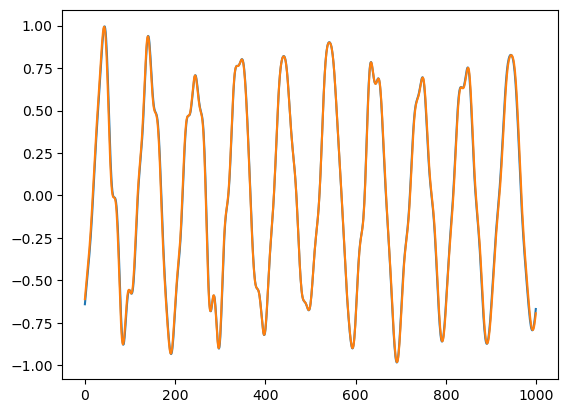

In [120]:
k = 1
l = 1
plt.plot(xs_new[:,k,l])
plt.plot(xs_old[:,k,l])